In [2]:
from utils import get_args
import os
import pandas as pd
import ehr_diagnosis_env
from ehr_diagnosis_env.envs import EHRDiagnosisEnv
import gymnasium
from tqdm import tqdm
from collections import Counter


args = get_args('config.yaml')
def get_instances_and_env(split, truncate=None):
    print(f'loading {split} dataset...')
    eval_df = pd.read_csv(os.path.join(
        args.data.path, args.data.dataset, f'{split}.data'),
        compression='gzip')
    print(f'length={len(eval_df)}')
    if truncate is not None:
        print(f'Truncating to {truncate}')
        eval_df = eval_df[:truncate]
    env: EHRDiagnosisEnv = gymnasium.make(
        'ehr_diagnosis_env/EHRDiagnosisEnv-v0',
        instances=eval_df,
        cache_path=args.env[f'{split}_cache_path'],
        llm_name_or_interface=None,
        fmm_name_or_interface=None,
        fuzzy_matching_threshold=None,
        reward_type=args.env.reward_type,
        num_future_diagnoses_threshold=args.env.num_future_diagnoses_threshold,
        progress_bar=lambda *a, **kwa: tqdm(*a, **kwa, leave=False),
        top_k_evidence=args.env.top_k_evidence,
        verbosity=1, # don't print anything when an environment is dead
        add_risk_factor_queries=args.env.add_risk_factor_queries,
        limit_options_with_llm=args.env.limit_options_with_llm,
        add_none_of_the_above_option=args.env.add_none_of_the_above_option,
        true_positive_minimum=args.env.true_positive_minimum,
        use_confident_diagnosis_mapping=
            args.env.use_confident_diagnosis_mapping,
        skip_instances_with_gt_n_reports=
            args.env.skip_instances_with_gt_n_reports,
    ) # type: ignore
    return eval_df, env


/work/frink/mcinerney.de/envs/ehragent/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_instances, train_env = get_instances_and_env('train', truncate=200)
val_instances, val_env = get_instances_and_env('val1', truncate=200)

loading train dataset...
length=32302
Truncating to 200
loading from cache: /work/frink/mcinerney.de/ehr-diagnosis-agent/ehr_diagnosis_agent/.cache/env_train_cache_2/extracted_info


100%|██████████| 31626/31626 [04:19<00:00, 121.95it/s, num_loaded=31626, num_deleted=0]


loading from cache: /work/frink/mcinerney.de/ehr-diagnosis-agent/ehr_diagnosis_agent/.cache/env_train_cache_2/processed_extracted_info


100%|██████████| 31103/31103 [04:37<00:00, 112.20it/s, num_loaded=31103, num_deleted=0]


loading from cache: /work/frink/mcinerney.de/ehr-diagnosis-agent/ehr_diagnosis_agent/.cache/env_train_cache_2/evidence


100%|██████████| 15360/15360 [02:01<00:00, 126.91it/s, num_loaded=15360, num_deleted=0]


loading val1 dataset...
length=3461
Truncating to 200
loading from cache: /work/frink/mcinerney.de/ehr-diagnosis-agent/ehr_diagnosis_agent/.cache/env_val1_cache_2/extracted_info


100%|██████████| 3376/3376 [00:26<00:00, 126.93it/s, num_loaded=3376, num_deleted=0]


loading from cache: /work/frink/mcinerney.de/ehr-diagnosis-agent/ehr_diagnosis_agent/.cache/env_val1_cache_2/processed_extracted_info


100%|██████████| 3342/3342 [00:34<00:00, 96.03it/s, num_loaded=3342, num_deleted=0] 


loading from cache: /work/frink/mcinerney.de/ehr-diagnosis-agent/ehr_diagnosis_agent/.cache/env_val1_cache_2/evidence


 86%|████████▋ | 2855/3304 [00:23<00:03, 113.80it/s, num_loaded=2859, num_deleted=0]

In [ ]:
train_instances_info = train_env.get_cached_instance_dataframe()
train_instances = train_instances.merge(
    train_instances_info, how='left', left_index=True, right_index=True)
train_instances = train_instances[~train_instances['target diagnoses'].isna()]
val_instances_info = val_env.get_cached_instance_dataframe()
val_instances = val_instances.merge(
    val_instances_info, how='left', left_index=True, right_index=True)
val_instances = val_instances[~val_instances['target diagnoses'].isna()]

In [ ]:
import io
from tqdm import tqdm
def get_simplified_dataset(instances):
    new_rows = []
    for i, row in tqdm(instances.iterrows(), total=len(instances)):
        evidence_snippets = []
        for k1, v1 in row.items():
            if isinstance(k1, tuple) and isinstance(v1, dict):
                for k2, v2 in v1.items():
                    if v2 != 'no evidence found':
                        evidence_snippets.append(v2)
        new_rows.append({
            'patient_id': row.patient_id,
            'evidence': evidence_snippets,
            'icd_codes': set(pd.read_csv(io.StringIO(row.codes)).code),
        })
        if row['target diagnoses'] == row['target diagnoses']:
            new_rows[-1]['target_diagnoses'] = row['target diagnoses'][0]
    return pd.DataFrame(new_rows)
train_df = get_simplified_dataset(train_instances)
val_df = get_simplified_dataset(val_instances)

100%|██████████| 197/197 [00:00<00:00, 723.17it/s]


In [ ]:
from sentence_transformers import util, SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
def encode_evidence(simplified_df):
    all_evidence = sum(simplified_df.evidence.tolist(), [])
    evidence_idx = [(i, j) for i in range(len(simplified_df)) for j in range(len(simplified_df.iloc[i].evidence))]
    encoded_evidence = model.encode(all_evidence, batch_size=64, show_progress_bar=True, convert_to_tensor=True)
    return all_evidence, evidence_idx, encoded_evidence
train_evidence, train_evidence_idx, train_encoded_evidence = encode_evidence(train_df)
val_evidence, val_evidence_idx, val_encoded_evidence = encode_evidence(val_df)

Batches: 100%|██████████| 143/143 [00:21<00:00,  6.53it/s]


In [ ]:

import time
from sklearn.cluster import KMeans
import torch
def cluster_sentences(evidence, encoded_evidence):
    start_time = time.time()
    clusters = util.community_detection(encoded_evidence, min_community_size=10, threshold=0.7)
    # cluster_vec = KMeans(n_clusters=500).fit_transform(encoded_evidence)
    # cluster_ids = cluster_vec.argmax(1)
    # clusters = [[] for _ in range(500)]
    # for i, cluster_id in enumerate(cluster_ids):
        # clusters[cluster_id].append(i)
    print("Clustering done after {:.2f} sec".format(time.time() - start_time))
    #Print for all clusters the top 3 and bottom 3 elements
    for i, cluster in enumerate(clusters):
        print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
        for sentence_id in cluster[0:3]:
            print("\t", evidence[sentence_id])
        print("\t", "...")
        for sentence_id in cluster[-3:]:
            print("\t", evidence[sentence_id])
    return clusters
def get_cluster_ids(simplified_df, clusters, evidence_idx, offset):
    cluster_ids = [{} for _ in range(len(simplified_df))]
    instance_ids = set()
    sentence_ids = set()
    for i, cluster in enumerate(clusters):
        for sentence_id in cluster:
            if sentence_id >= offset and sentence_id < offset + len(evidence_idx):
                sentence_ids.add(sentence_id)
                instance_idx, sentence_idx = evidence_idx[sentence_id - offset]
                instance_ids.add(instance_idx)
                cluster_ids[instance_idx][sentence_idx] = i
    simplified_df['evidence_clusters'] = [
        [x[j] if j in x.keys() else None
         for j in range(len(simplified_df['evidence'].iloc[i]))]
        for i, x in enumerate(cluster_ids)]
    # TODO: measure closeness to cluster mean or median?
    simplified_df['clusters'] = [
        {i: 1 for i in set(x) if i is not None}
        for x in simplified_df['evidence_clusters']]
clusters = cluster_sentences(
    train_evidence + val_evidence,
    torch.cat([train_encoded_evidence, val_encoded_evidence]))
get_cluster_ids(train_df, clusters, train_evidence_idx, 0)
get_cluster_ids(val_df, clusters, val_evidence_idx, len(train_evidence_idx))

Clustering done after 32.00 sec

Cluster 1, #1002 Elements 
	 The patient has a PICC line in place.
	 The patient has a chest tube in place.
	 The patient has a chest tube.
	 ...
	 The patient is on a ventilator.
	 The patient is on a ventilator.
	 The patient is intubated.

Cluster 2, #470 Elements 
	 The patient has a dilated right ventricle.
	 The patient has a heart condition that can cause a rapid heartbeat.
	 The patient has a heart murmur.
	 ...
	 The patient has sinus bradycardia.
	 The patient has a high blood pressure.
	 The patient has a heart condition that causes a rapid heartbeat.

Cluster 3, #448 Elements 
	 A large left pneumothorax is again noted.
	 Moderate left pneumothorax, predominantly basal and medial has improved slightly, although I see no change in the position of two left pleural tubes, one of which is fissural and the other apical and
	 The patient has a pleural effusion.
Signs: a moderate right pleural effusion is also larger
	 ...
	 There are small bilater

<Axes: >

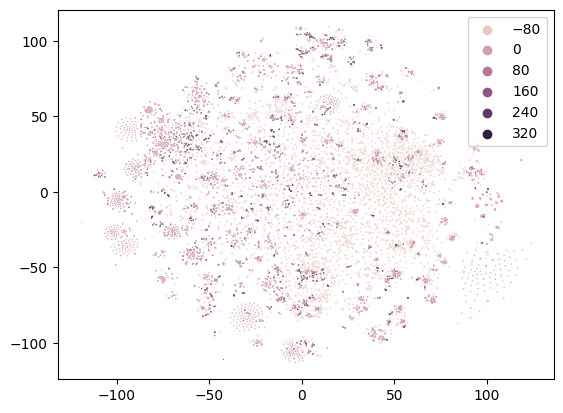

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
X = TSNE().fit_transform(
    torch.cat([train_encoded_evidence, val_encoded_evidence]).numpy())
hue = sum(train_df.evidence_clusters.tolist()
          + val_df.evidence_clusters.tolist(), [])
hue = [x if x is not None else -100 for x in hue]
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=hue, s=1)

In [ ]:
train_df

,patient_id,evidence,icd_codes,target_diagnoses,evidence_clusters,clusters
0,7721,[GBS + maternal colonization],"{7455, V053, 77989, V3001}",{},[None],{}
1,42555,"[Constitutional: Fatigue, Constitutional: Fati...","{2859, V5864, 53140, 53561, E9359, V1052, 4019...",{},"[325, 325, None, None, None, None, None, None,...",{325: 1}
2,28622,[Rectal temp 98.7],"{V290, 7661, V053, V3000}",{},[None],{}
3,72627,"[The ET tube tip is 5 cm above the carina., Th...","{34889, 36846, 42769, 4019, 42732, 53081, 2766...",{},"[None, None, None, 50, None, 17, 5, 6, 11, 66,...","{0: 1, 66: 1, 5: 1, 6: 1, 7: 1, 201: 1, 11: 1,..."
4,82434,[Mediastinal and bilateral hilar lymph node en...,"{8170, 9212, E8798, 51852, 4588, 80708, 496, 5...",{pulmonary edema},"[None, 7, 19, 7, None, 14, 14, None, None, 2, ...","{0: 1, 161: 1, 2: 1, 5: 1, 7: 1, 236: 1, 14: 1..."
...,...,...,...,...,...,...
192,22566,"[There is normal compression, augmentation and...","{5723, 73300, V1046, 78039, 4589}",{},"[None, None, 214, None, 7, 131, None, 22, 1, N...","{1: 1, 289: 1, 131: 1, 101: 1, 6: 1, 7: 1, 41:..."
193,98554,[The patient has urosepsis. Urosepsis is a med...,"{28850, 7291, E8798, E8497, 2762, 03842, E9310...",{},"[None, None, None, None, None, None, None, 3, ...","{3: 1, 5: 1, 39: 1, 40: 1, 11: 1, 16: 1, 304: ..."
194,93054,[The patient is intubated.\nSigns: Diffuse ede...,"{514, V0254, 0389, 78550, E8798, 57480, 7824, ...",{pulmonary edema},"[None, 22, 7, 107, 236, 7, 85, 5, None, None, ...","{0: 1, 130: 1, 2: 1, 3: 1, 5: 1, 6: 1, 7: 1, 1..."
195,45092,[Atrial fibrillation with rapid ventricular re...,"{6827, V4975, 70709, 4242, 45829, 5119, 41401,...","{pneumonia, pulmonary edema}","[217, None, None, None, 217, 0, None, 236, Non...","{0: 1, 1: 1, 258: 1, 2: 1, 6: 1, 7: 1, 9: 1, 2..."


In [ ]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
train_x = vec.fit_transform(train_df.clusters.tolist()).toarray()
yvec = DictVectorizer()
train_y = yvec.fit_transform(train_df.target_diagnoses.apply(lambda x: {str(i): 1 for i in x}).tolist()).toarray()
val_x = vec.transform(val_df.clusters.tolist()).toarray()
val_y = yvec.transform(val_df.target_diagnoses.apply(lambda x: {i: 1 for i in x}).tolist()).toarray()

In [16]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier
fitmodel = MultiOutputClassifier(SGDClassifier(loss='log_loss')).fit(train_x, train_y)

In [31]:
import numpy as np
val_preds = fitmodel.predict_proba(val_x)
val_preds = np.stack([x[:, 1] for x in val_preds])

In [1]:
yvec.inverse_transform([[0, 1, 0]])

NameError: name 'yvec' is not defined

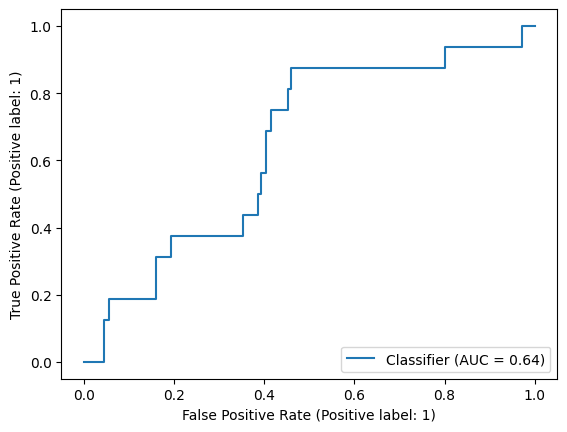

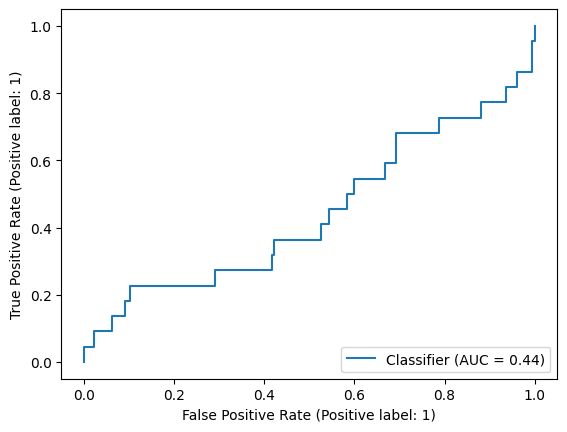

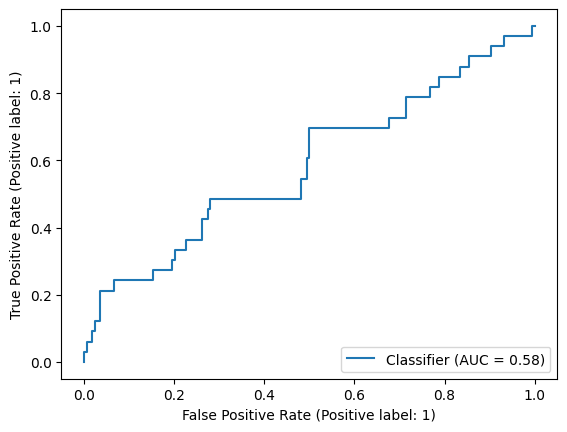

In [33]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score, f1_score
RocCurveDisplay.from_predictions(val_y[:, 0], val_preds[0])
RocCurveDisplay.from_predictions(val_y[:, 1], val_preds[1])
RocCurveDisplay.from_predictions(val_y[:, 2], val_preds[2])